# ML Term Paper - Code: Models
by Ann-Christin and Sarah 15/02/2021

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
import os
path = "C:/Users/gust/Documents/ML_term_paper"  # specify your path here
os.chdir(path)
data = pd.read_csv("Data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

C:\Users\gust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,5,12,18,23,25,26,29,31,32,39,48,51,58,59,60,63,64,66,69,76,85,86,87,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(230691, 130)

In [3]:
data.head()


,Unnamed: 0,cntry,cntry_e,inpiaac,seqid,cnt_brth,ageg10lfs,age_r,gender_r,j_q03b,...,nfe12jr,nfe12njr,fnfaet12,fnfaet12jr,fnfaet12njr,nfehrsnjr,nfehrsjr,nfehrs,nopaidworkever,unempflag
0,0,USA,USA,1.0,9355.0,NaN,NaN,NaN,Male,NaN,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
1,1,USA,USA,1.0,10882.0,NaN,NaN,NaN,Male,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,30.0,30.0,Has had paid work,0.0
2,2,USA,USA,1.0,12329.0,NaN,NaN,NaN,Female,NaN,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
3,3,USA,USA,1.0,10711.0,NaN,NaN,NaN,Female,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,NaN,NaN,8.0,Has had paid work,0.0
4,4,USA,USA,1.0,10383.0,NaN,NaN,NaN,Male,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,80.0,80.0,Has had paid work,0.0


In [63]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0', 'cntry', 'cntry_e', 'inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c"])
dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]

In [64]:
thresh = len(dcl) * .18
dcl.dropna(thresh = thresh, axis = 1, inplace = True)
dcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 93 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cnt_brth            160270 non-null  object 
 1   ageg10lfs           227031 non-null  object 
 2   age_r               166949 non-null  float64
 3   gender_r            230689 non-null  object 
 4   j_q03b              103091 non-null  float64
 5   j_q04a              228012 non-null  object 
 6   pared               215610 non-null  object 
 7   computerexperience  227980 non-null  object 
 8   isced_hf            224767 non-null  object 
 9   cnt_h               148940 non-null  object 
 10  yrsqual             218593 non-null  float64
 11  yrsget              125736 non-null  float64
 12  vet                 102508 non-null  object 
 13  edcat8              188436 non-null  object 
 14  leaver1624          43455 non-null   object 
 15  b_q01a              193958 non-nul

In [65]:
cate = dcl.select_dtypes(include=['object'])
cate = list(set(cate))
cate

['pared',
 'b_q02a_t2',
 'd_q13c',
 'd_q06b',
 'd_q04_t',
 'b_q12e',
 'b_q12a',
 'aetpop',
 'b_q14a',
 'd_q14',
 'd_q12b',
 'g_q05e',
 'f_q07a',
 'd_q12a',
 'b_q01b',
 'faet12jr',
 'vet',
 'b_q04a',
 'j_q04a',
 'nfe12jr',
 'g_q05h',
 'g_q06',
 'fnfaet12jr',
 'd_q04',
 'g_q05f',
 'faet12njr',
 'g_q05g',
 'fe12',
 'b_q26a_t',
 'b_q02a',
 'g_q05d',
 'fnfaet12',
 'b_q20b',
 'cnt_brth',
 'nfe12njr',
 'g_q05c',
 'b_q02a_t1',
 'd_q06a',
 'b_q12c',
 'isco1c',
 'c_q02a',
 'b_q13',
 'f_q07b',
 'leaver1624',
 'edcat8',
 'isic1c',
 'isco1l',
 'faet12',
 'b_q26b',
 'c_d05',
 'b_q16',
 'cnt_h',
 'b_q01a_t',
 'isced_hf',
 'b_q15c',
 'c_d06',
 'b_q15b',
 'g_q07',
 'd_q09',
 'ageg10lfs',
 'g_q08',
 'd_q06c',
 'b_q01a',
 'c_d09',
 'fnfaet12njr',
 'g_q05a',
 'computerexperience',
 'nopaidworkever',
 'd_q03',
 'b_q14b',
 'iscoskil4',
 'b_q12g',
 'g_q04',
 'isic1l',
 'b_d12h',
 'd_q12c',
 'nfe12',
 'gender_r',
 'b_q15a']

In [66]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [67]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsqual        218593 non-null  float64
 3   yrsget         125736 non-null  float64
 4   c_q09          160575 non-null  float64
 5   c_q10a         147420 non-null  float64
 6   d_q05a2        94539 non-null   float64
 7   d_q16b         71135 non-null   float64
 8   readytolearn   226734 non-null  float64
 9   icthome        171755 non-null  float64
 10  ictwork        102478 non-null  float64
 11  earnmthallppp  88508 non-null   float64
dtypes: float64(12)
memory usage: 21.1 MB


In [68]:
num_list = list(set(num))
num_list

['d_q05a2',
 'age_r',
 'd_q16b',
 'icthome',
 'readytolearn',
 'c_q09',
 'ictwork',
 'c_q10a',
 'yrsqual',
 'j_q03b',
 'earnmthallppp',
 'yrsget']

In [69]:
# generate dummies
dummies = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies = dummies.pop(0)
dummies = pd.DataFrame(dummies)
dummies.info()
dummies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 626 entries, pared_At least one parent has attained tertiary to b_q15a_Yes
dtypes: uint8(626)
memory usage: 137.7 MB


,pared_At least one parent has attained tertiary,pared_Neither parent has attained upper secondary,b_q02a_t2_Yes,d_q13c_Every day,d_q13c_Less than once a month,d_q13c_Less than once a week but at least once a month,d_q13c_Never,d_q06b_Increased,d_q06b_Stayed more or less the same,"d_q04_t_Employee, supervising fewer than 5 people",...,b_d12h_Respondent reported more than 1 learning activity,b_d12h_Respondent reported no learning activities,d_q12c_1 to 6 months,d_q12c_3 years or more,d_q12c_7 to 11 months,d_q12c_Less than 1 month,d_q12c_None,nfe12_Participated in NFE,gender_r_Male,b_q15a_Yes
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1


In [84]:
# define X and y
on_job = dcl["b_q12d"] #define y here
open_educ = dcl["b_q12f"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
y = pd.DataFrame(dict(on_job = on_job, open_educ = open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsqual,yrsget,c_q09,c_q10a,d_q05a2,d_q16b,...,b_d12h_Respondent reported more than 1 learning activity,b_d12h_Respondent reported no learning activities,d_q12c_1 to 6 months,d_q12c_3 years or more,d_q12c_7 to 11 months,d_q12c_Less than 1 month,d_q12c_None,nfe12_Participated in NFE,gender_r_Male,b_q15a_Yes
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,NaN,NaN,NaN,NaN,19.0,19.0,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,NaN,NaN,NaN,NaN,8.0,8.0,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
230687,NaN,NaN,NaN,NaN,11.0,11.0,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
230688,NaN,NaN,NaN,NaN,12.0,11.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
230689,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [88]:
nona = y_X.dropna()
nona

,on_job,open_educ,age_r,j_q03b,yrsqual,yrsget,c_q09,c_q10a,d_q05a2,d_q16b,...,b_d12h_Respondent reported more than 1 learning activity,b_d12h_Respondent reported no learning activities,d_q12c_1 to 6 months,d_q12c_3 years or more,d_q12c_7 to 11 months,d_q12c_Less than 1 month,d_q12c_None,nfe12_Participated in NFE,gender_r_Male,b_q15a_Yes
18471,8.0,1.0,40.0,2.0,11.0,13.0,21.0,1.0,1993.0,1600.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
18491,3.0,3.0,32.0,2.0,13.0,13.0,3.0,2.0,2010.0,1200.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18504,50.0,3.0,38.0,1.0,13.0,12.0,15.0,1.0,1999.0,2600.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
18600,3.0,5.0,47.0,3.0,13.0,13.0,22.0,1.0,1992.0,2700.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
18619,3.0,2.0,49.0,1.0,13.0,13.0,29.0,1.0,1986.0,2000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225472,1.0,9.0,45.0,4.0,16.0,16.0,20.0,7.0,2011.0,4600.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
225485,3.0,1.0,44.0,2.0,13.0,13.0,27.0,1.0,1985.0,4000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
225518,4.0,2.0,47.0,2.0,15.0,15.0,21.0,5.0,1993.0,3000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
225522,4.0,2.0,32.0,2.0,16.0,16.0,7.0,3.0,2011.0,3000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [72]:
on_job.describe()

count    46750.000000
mean         3.252021
std          4.441589
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         50.000000
Name: b_q12d, dtype: float64

In [73]:
open_educ.describe()

count    42328.000000
mean         3.026295
std          3.832335
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         50.000000
Name: b_q12f, dtype: float64

## OLS

In [74]:
# run OLS on job
import statsmodels.api as sm
est = sm.OLS(on_job, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 b_q12d   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     4.545
Date:                Mon, 22 Feb 2021   Prob (F-statistic):          5.28e-160
Time:                        17:13:57   Log-Likelihood:                -30233.
No. Observations:               10903   AIC:                         6.126e+04
Df Residuals:                   10504   BIC:                         6.418e+04
Df Model:                         398                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                          -0.0184      0.016     -1.137      0.256      -0.050       0.013
j_q03b                                                                                         -0.0012      0.045     -0.026      0.979      -0.089       0.087
yrsqual                                                                                        -0.1841      0.065     -2.851      0.004      -0.311      -0.058
yrsget                                                                                          0.0649      0.059      1.097      0.272      -0.051       0.181
c_q09                                                                                           0.0272      0.009      3.041      0.002       0.010       0.045
c_q10a                                                                                          0.0782      0.037      2.110      0.035       0.006       0.151
d_q05a2                                                                                         0.0027      0.005      0.528      0.598      -0.007       0.013
d_q16b                                                                                      -3.309e-09   6.93e-09     -0.478      0.633   -1.69e-08    1.03e-08
readytolearn                                                                                    0.1342      0.048      2.789      0.005       0.040       0.229
icthome                                                                                         0.0014      0.054      0.025      0.980      -0.104       0.107
ictwork                                                                                         0.0987      0.154      0.641      0.522      -0.203       0.401
earnmthallppp                                                                                 6.82e-07   2.52e-06      0.271      0.787   -4.25e-06    5.62e-06
pared_At least one parent has attained tertiary                                                 0.0255      0.102      0.251      0.802      -0.174       0.225
pared_Neither parent has attained upper secondary                                              -0.0971      0.099     -0.984      0.325      -0.290       0.096
b_q02a_t2_Yes                                                                                   1.0407      0.820      1.269      0.204      -0.567       2.648
d_q13c_Every day                                                                                0.2184      0.116      1.890      0.059      -0.008       0.445
d_q13c_Less than once a month              

In [20]:
# run OLS on job
import statsmodels.api as sm
est = sm.OLS(open_educ, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 b_q12f   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.953
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           4.06e-66
Time:                        16:55:03   Log-Likelihood:                -20616.
No. Observations:                8073   AIC:                         4.198e+04
Df Residuals:                    7700   BIC:                         4.459e+04
Df Model:                         372                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                          -0.1891      1.394     -0.136      0.892      -2.921       2.543
age_r                                                                                           0.0164      0.015      1.078      0.281      -0.013       0.046
j_q03b                                                                                         -0.0197      0.041     -0.482      0.630      -0.100       0.060
yrsqual                                                                                         0.0251      0.064      0.394      0.694      -0.100       0.150
yrsget                                                                                          0.0011      0.062      0.018      0.986      -0.120       0.122
c_q09                                                                                           0.0083      0.008      0.993      0.321      -0.008       0.025
c_q10a                                                                                         -0.0020      0.033     -0.061      0.951      -0.066       0.062
d_q05a2                                                                                         0.0015      0.005      0.317      0.751      -0.008       0.011
d_q16b                                                                                       7.546e-09   5.37e-09      1.406      0.160   -2.97e-09    1.81e-08
readytolearn                                                                                    0.1630      0.045      3.630      0.000       0.075       0.251
icthome                                                                                         0.0445      0.051      0.868      0.385      -0.056       0.145
ictwork                                                                                         0.3106      0.146      2.123      0.034       0.024       0.597
earnmthallppp                                                                                 4.12e-06   3.42e-06      1.204      0.229   -2.59e-06    1.08e-05
pared_At least one parent has attained tertiary                                                 0.0002      0.092      0.002      0.998      -0.179       0.180
pared_Neither parent has attained upper secondary                                              -0.1402      0.094     -1.492      0.136      -0.324       0.044
b_q02a_t2_Yes                                                                                   1.1266      0.845      1.334      0.182      -0.529       2.783
d_q13c_Every day                           

## Pipeline, standardisation, simple sample-splitting

In [89]:
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

nona = y_X.dropna()

y = nona["on_job"]
X = nona.iloc[:, 2:]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #this splits the data into a training and a test set. In real application, try to use as much training data as possible - 80%/20% or

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('regr', LinearRegression(fit_intercept = False, normalize=False, copy_X=False, n_jobs=-1))])
# The pipeline can be used with any other estimator
# It avoids leaking the test set into the train set

pipe.fit(X_train, y_train) #it estimates the data and then fits the model 
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq: -9.1567
Out-of-sample Rsq: -294529515708502895839804391424.0000


# Feature selection with Benjamini - Hochberg Algorithm

In [90]:
from sklearn.feature_selection import SelectFdr, f_regression

fdr = SelectFdr(f_regression, alpha=0.05) # here alpha is our acceptable rate of finding false positives 
X_new =fdr.fit_transform(X, y) 

C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selecti

In [91]:
print(X.shape, X_new.shape)

(5535, 638) (5535, 65)


In [92]:
# Cutoff pvalue for selected features 
sorted = pd.Series(fdr.pvalues_.T).sort_values(axis=0, ascending=True).reset_index(drop = True)
print("Cutoff p-value: % .4f" % sorted.loc[X_new.shape[1]])

Cutoff p-value:  0.0060


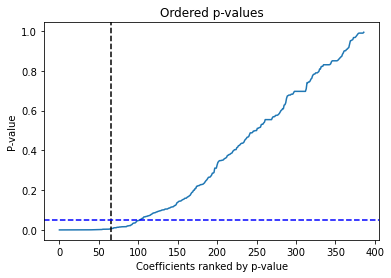

In [93]:
# Plot ordered pvalues
ax = sorted.plot.line(title = "Ordered p-values")
ax.set(xlabel="Coefficients ranked by p-value", ylabel="P-value")
ax.axvline(X_new.shape[1], color='k', linestyle='--')
ax.axhline(0.05, color='b', linestyle='--', label = 'p-value = 0.1')
ax

In [94]:
# Again we can get a rough idea of the prediction power using sample-splitting 

y = nona["on_job"]
X = nona.iloc[:, 2:]

# ! it is more correct to perform FDR only on the train data, therefore it is inside the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.1)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train)) #In sample fit decreases afte throughing out variables
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test)) # Out of sample fit did not increase by much

In-sample Rsq:  0.1062
Out-of-sample Rsq:  0.0069


C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:675: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\skl

In [95]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["on_job"]
X = nona.iloc[:, 2:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

[-6.63811801e+25 -4.06759858e+25 -1.34224626e+26 -2.54094966e+24
 -3.32421220e+25]
Accuracy: -55412972617757372073377792.00000 (+/- 88705149486173951868534784.00000)


In [96]:
y = nona["on_job"]
X = nona.iloc[:, 2:]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.05)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_reduced = cross_val_score(pipe, X, y, cv=kf)
print(scores_reduced)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_reduced.mean(), scores_reduced.std() * 2))

C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:675: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\skl

[-0.06337002  0.0477829   0.0088564   0.02090662  0.04174746]
Accuracy: 0.01118 (+/- 0.07966)


C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:675: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()


Text(0.5, 1.0, 'Out-of-sample validation')

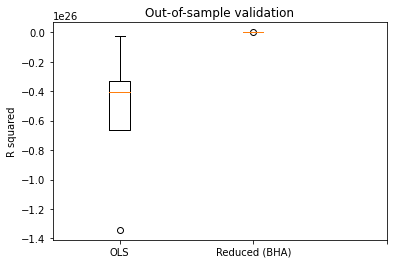

In [98]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced])
plt.xticks([1, 2, 3], ['OLS', 'Reduced (BHA)'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation')

## Lasso

In [102]:
from sklearn.linear_model import lasso_path, enet_path

y = nona["on_job"]
X = nona.iloc[:, 2:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.005, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))]) 
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))
#print(regr.coef_)

# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

In-sample Rsq:  0.1574
Out-of-sample Rsq: -0.0767
Computing regularization path using the lasso...
Ready


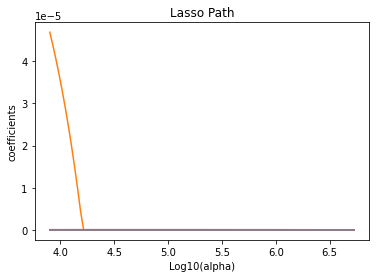

In [103]:
# Display results
plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()

In [104]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

y = nona["on_job"]
X = nona.iloc[:, 2:]

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-2.2, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")

Computing Lasso CV...
Ready


In [105]:
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Optimal alpha =  0.0892 
Training time =  7.7283s 


(-2.285, -0.415, 6.18890985305887, 49.1478672107135)

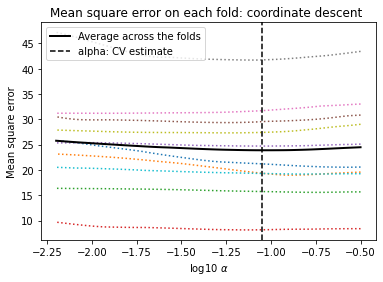

In [106]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')

In [107]:
y = nona["on_job"]
X = nona.iloc[:, 2:]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

# if you decide to check for AIC, will take time, as lambda is very small, the result will be very close to a simple OLS

[-0.00471471  0.04473317  0.05443655  0.03344234  0.04391887]
Accuracy: 0.03436 (+/- 0.04128)


Text(0.5, 1.0, 'Out-of-sample validation')

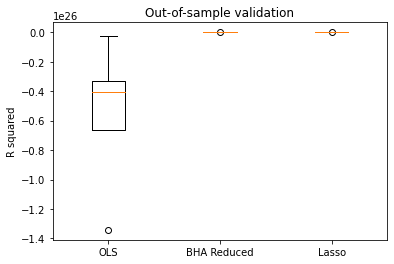

In [108]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced, scores_lasso])
plt.xticks([1, 2, 3], ['OLS', 'BHA Reduced', 'Lasso'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation')

# Random Forest 

In [ ]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)
